In [1]:
# As will become standard in all notebooks
# we will import the following packages 

## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

# Simple Linear Regression

In this notebook we start the unit on regression, but also start learning about basic machine learning procedures.

Let's get going with one of the most straightforward algorithms simple linear regression. As we learn about the algorithm we'll also have machine learning (ML) asides. These will introduce some basic ML concepts in the context of Simple Linear Regression.

### The Problem

Let's say you want to predict something. Actually let's get more specific. You work for ESPN and you think that you can predict a baseball teams wins, if you know their run differential. 

<i>For non-baseball fans a run is considered $1$ point in baseball, and run differential is the number of runs your team scores, denoted as $r$, minus the number of runs your team gave up, denoted as $ra$ for runs allowed, so run differential is $rd = r - ra$).</i>

Luckily we have data that can help us identify the validity of that statement.

In [2]:
# Use pandas to import the data
baseball = pd.read_csv("baseball_run_diff.csv")

print("There are",len(baseball),"observations in the baseball df.")
print("The columns are",list(baseball.columns))

# Look at 5 randomly sampled rows
baseball.sample(5)

There are 540 observations in the baseball df.
The columns are ['teamID', 'yearID', 'lgID', 'G', 'W', 'L', 'R', 'RA', 'RD']


,teamID,yearID,lgID,G,W,L,R,RA,RD
128,COL,2005,NL,162,67,95,740,862,-122
82,PIT,2003,NL,162,75,87,753,801,-48
422,BAL,2015,AL,162,81,81,713,693,20
436,MIN,2015,AL,162,83,79,696,700,-4
179,WAS,2006,NL,162,71,91,746,872,-126


##### ML Aside - First Step in ML Data Handling Train Test Split

We've imported the baseball data we'll need. Now you may be tempted to start exploring this data. However, since we'll be building a predictive model on top of it we want to set aside a small subset of the data aside for testing purposes. This is known as making the <i>train test split</i>.

The <i>train set</i> is the one we build our model on. Most algorithms are built to optimize performance on the train set, so we can get a reliable sense of their prediction performance on this set. So by setting aside the <i>test set</i> at the beginning of the process, we can simulate how our model performs on new data because the model was not built on the test set, like new data, but we know the true answer, not like new data.

So let's use `pandas` to make our sets.

In [3]:
# first make a copy of the original dataframe
# this is due to the way python internally 
# stores objects
baseball_copy = baseball.copy()

# Now use sample to make a random sample
# frac allows us to choose a fraction of the df
# it is common to set aside 25% for testing
baseball_train = baseball_copy.sample(frac=.75, random_state = 440)

# now use drop and the train index to make test
baseball_test = baseball_copy.drop(baseball_train.index)

In [4]:
# Now look at the training set head
baseball_train.head()

,teamID,yearID,lgID,G,W,L,R,RA,RD
385,SLN,2013,NL,162,97,65,783,596,187
39,COL,2002,NL,162,73,89,778,898,-120
335,CHN,2012,NL,162,61,101,613,759,-146
125,CHN,2005,NL,162,79,83,703,714,-11
158,COL,2006,NL,162,76,86,813,812,1


Now we can explore!

Let's learn some plotting techniques so we can assess whether or not there is a relationship between run differential (coded as `RD` in the df) and wins (coded as `W`).

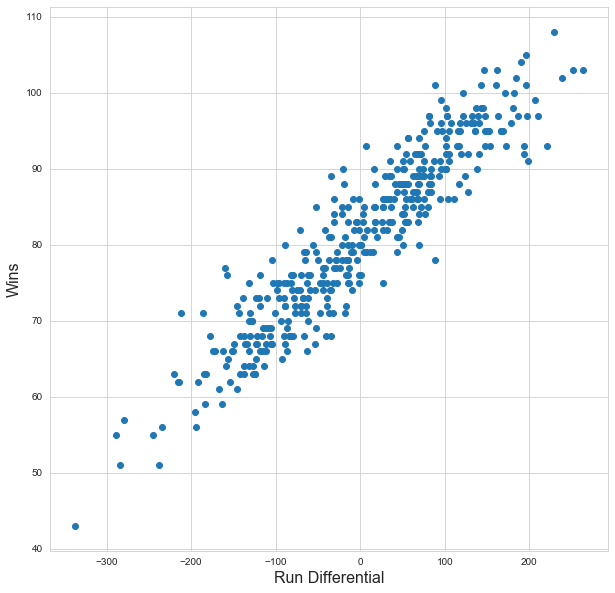

In [5]:
# We'll use plt.scatter for this

# first make a figure
# this makes a figure that is 10 units by 10 units
plt.figure(figsize = (10,10))

# plt.scatter plots RD on the x and W on the y
plt.scatter(baseball_train.RD, baseball_train.W)

# Always good practice to label well when
# presenting a figure to others
# place an xlabel
plt.xlabel("Run Differential", fontsize =16)

# place a ylabel
plt.ylabel("Wins", fontsize = 16)

# type this to show the plot
plt.show()

##### Write Something

Take a moment to describe what relationship you see between run differential and wins.










We want to predict wins given run differential. There are many ways to do this, for example we could just predict that the number of wins is equal to the average from the training set, essentially saying that run differential doesn't matter.

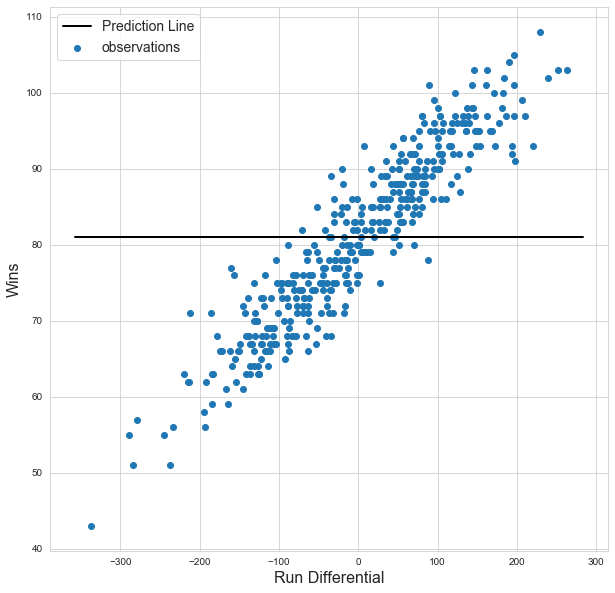

In [6]:
# use pandas to get mean wins
mean_w = baseball_train.W.mean()

# now get min and max rd for plotting
min_rd = baseball_train.RD.min()
max_rd = baseball_train.RD.max()
padding = 20

plt.figure(figsize = (10,10))

# plt.scatter plots RD on the x and W on the y
plt.scatter(baseball_train.RD, baseball_train.W, label = "observations")

# Now add mean prediction line
plt.plot(np.linspace(min_rd - padding,max_rd + padding,1000),
            mean_w*np.ones(1000), 'k',
            label="Prediction Line",
            linewidth = 2)

# Always good practice to label well when
# presenting a figure to others
# place an xlabel
plt.xlabel("Run Differential", fontsize =16)

# place a ylabel
plt.ylabel("Wins", fontsize = 16)

# Add a legend
plt.legend(fontsize=14)

# type this to show the plot
plt.show()


What do you think? Can we do better?

Yes!

Let's use that relationship you discussed after we first plotted Run Differential against Wins. There definitely seems to be a linear relationship between the two variables, and modeling this relationship is exactly what simple linear regression is all about.

### The Model

Copying the notation of our dataframe let $w$ denote wins and $rd$ denote run differential, also assume we have $n$ observations. In many machine learning and data science problems you assume some model of the truth. Meaning this, we're assuming there is some true relationship between $rd$ and $w$, a statistical model allows us to estimate the truth so we can make informed decisions and predictions.

For Simple Linear Regression we model the relationship like a straight line, let the subscript $i$ denote the $i_{\text{th}}$ observation:
$$
w_i = \beta_0 + \beta_1 rd_i + \epsilon_i,
$$
here $\beta_0$ and $\beta_1$ are coefficients we'll need to estimate, and $\epsilon_i$ is random noise assumed to be an independent normally distributed with mean $0$ and standard deviation $\sigma$. Note that we assume the same formula holds for all observations.

#### How to Fit the Model

We need to choose $\beta_0$ and $\beta_1$ so that the line we produce is "good", but what does "good" mean. In general it means that we don't want our estimated line to be too far from the data. A common measure used in regression problems is the <i>Mean Square Error (MSE)</i> or equivalently the <i>Root Mean Square Error</i>. Suppose that we decide that $\hat{\beta_0}$ and $\hat{\beta_1}$ are the best estimates, then the MSE for those estimates is
$$
MSE = \frac{1}{n}\sum_i^n(\hat{w_i} - w_i)^2 = \frac{1}{n}\sum_i^n(\hat{\beta_0} + \hat{\beta_1}rd_i - w_i)^2.
$$
The "best" estimates will be the $\hat{\beta_0}$ and $\hat{\beta_1}$ that minimize the MSE. Doing some Calculus you can derive that this gives the following best linear estimates for the $\hat{\beta}$s:
$$
\hat{\beta_1} = \frac{\sum_i^n\left(rd_i - \overline{rd}\right)\left(w_i - \overline{w}\right)}{\sum_i^n\left(rd_i - \overline{rd}\right)^2} = \frac{\text{cov}(rd,w)}{\sigma^2_{rd}}, \text{ and}
$$
<br>
$$
\hat{\beta_0} = \overline{w} - \hat{\beta_1}\overline{rd}.
$$
These two formulas give the <i>least squares coefficient estimatesw</i> for simple linear regression.

Let's have you do a little coding and calculate the least squares estimate for regressing wins on run differential.

In [7]:
## Code here
## Note you can get a column's variance using .var()
## Note you can get a covariance matrix from a dataframe using .cov()

## Sample Answer
w_mean = baseball_train.W.mean()
rd_mean = baseball_train.RD.mean()

cov = baseball_train[['W','RD']].cov().iloc[0,1]
rd_var = baseball_train.RD.var()

beta_1_hat = cov/rd_var
beta_0_hat = w_mean - beta_1_hat * rd_mean

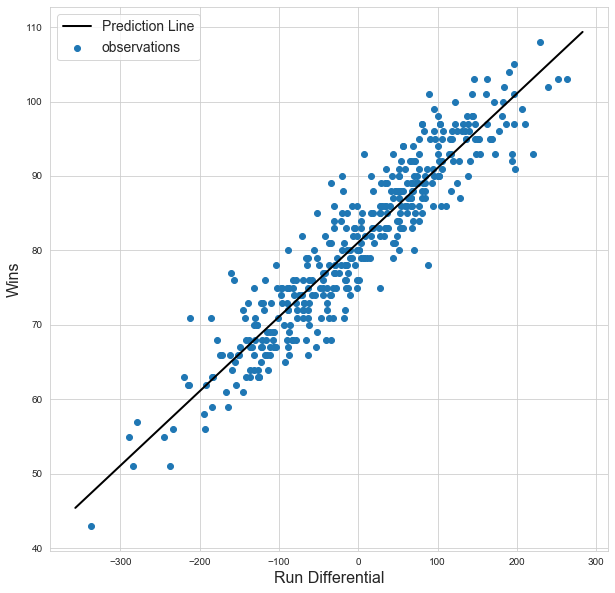

In [8]:
## Code here
## Now produce a plot with the samples and the fitted SLR line

## Use the x as the input for your line, i.e. beta_0_hat + beta_1_hat*x
min_rd = baseball_train.RD.min()
max_rd = baseball_train.RD.max()
padding = 20
x = np.linspace(min_rd - padding,max_rd + padding,1000)



## Sample Answer
plt.figure(figsize = (10,10))

# plt.scatter plots RD on the x and W on the y
plt.scatter(baseball_train.RD, baseball_train.W, label = "observations")

# Now add mean prediction line
plt.plot(np.linspace(min_rd - padding,max_rd + padding,1000),
            beta_0_hat + beta_1_hat*np.linspace(min_rd - padding,max_rd + padding,1000), 'k',
            label="Prediction Line",
            linewidth = 2)

# Always good practice to label well when
# presenting a figure to others
# place an xlabel
plt.xlabel("Run Differential", fontsize =16)

# place a ylabel
plt.ylabel("Wins", fontsize = 16)

# Add a legend
plt.legend(fontsize=14)

# type this to show the plot
plt.show()

Now that looks a lot better than our previous mean only prediction!

Great Work!

##### ML Aside

MSE is just one example of what is called a <i>loss function</i> or <i>cost function</i>. In Machine Learning problems we often fit our models by minimizing the loss function. For example, to find the $\beta_0$ and $\beta_1$ estimates we minimized MSE. We'll see many examples of loss functions as we go along in the course.

##### Aside Over

#### `sklearn` and `seaborn` Shortcuts

Now that we did all that work let's see a couple of shortcuts.

In [9]:
## Model Building with sklearn

# first we import Linear Regression from sklearn
from sklearn.linear_model import LinearRegression

In [10]:
# Now we make a model object
slr = LinearRegression(copy_X = True)

# Now we fit the model
# first goes the input variables
# Then the output variables
# If the input is a 1-D vector you need to reshape it
# Then you need to ravel() the output
slr.fit(baseball_train['RD'].values.reshape(-1,1), baseball_train['W'].values.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
# Now we can see the coefficients
print("beta_1_hat is", slr.coef_[0])
print("beta_0_hat is", slr.intercept_)

print()

# Let's compare that to what we computed
print("We computed beta_1_hat to be", beta_1_hat)
print("We compute beta_0_hat to be", beta_0_hat)

beta_1_hat is 0.09985459099626864
beta_0_hat is 81.08682310353349

We computed beta_1_hat to be 0.09985459099626862
We compute beta_0_hat to be 81.08682310353349


In [12]:
# We can make predictions like so
min_rd = baseball_train.RD.min()
max_rd = baseball_train.RD.max()
padding = 20
x = np.linspace(min_rd - padding,max_rd + padding,10)

slr.predict(x.reshape(-1,1))

array([ 45.43873412,  52.53950503,  59.64027595,  66.74104686,
        73.84181778,  80.94258869,  88.04335961,  95.14413052,
       102.24490144, 109.34567236])

`sklearn` is <b>the</b> Python machine learning library. As we go throught the course we'll be relying heavily on `sklearn`. The pattern we just showed is the common `sklearn` pattern, import the model, make a model object, fit the object, then predict. To learn more about the `LinearRegression` object read the documentation here: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html">https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html</a>.

Now let's introduce a nice plotting shortcut.

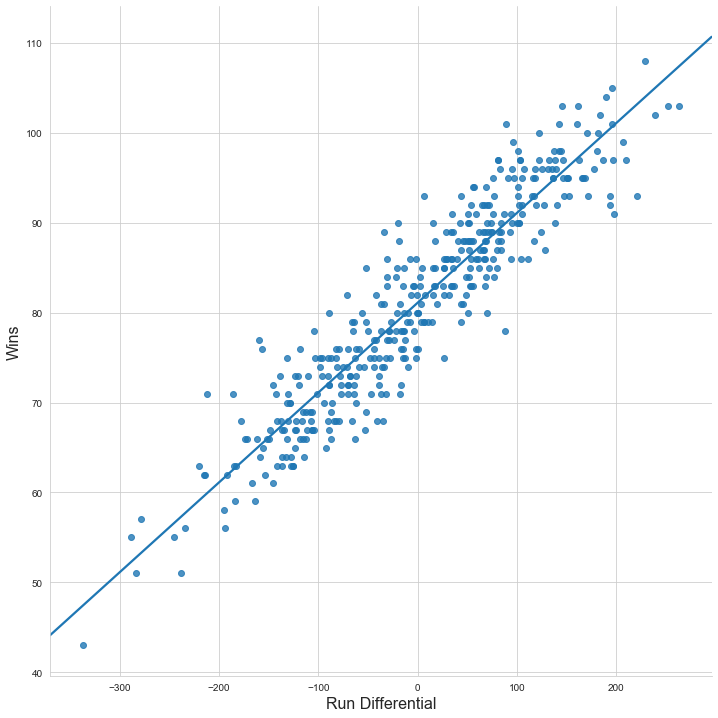

In [13]:
## Now we can have a nice plotting shortcut too

# seaborn lmplot stands for 
# linear model plot
# it makes a scatter plot and plots the regression plot over it
# height controls the size of the plot
# ci stands for confidence interval, we'll come back to that later
sns.lmplot(data = baseball_train, x = 'RD', y = 'W', height = 10, ci=None)


plt.xlabel("Run Differential", fontsize = 16)
plt.ylabel("Wins", fontsize = 16)

plt.show()

`seaborn` is an excellent plotting library. We'll leave it to you to explore it separately. Here is the documentation page <a href="https://seaborn.pydata.org/index.html">https://seaborn.pydata.org/index.html</a>, and here is a nice tutorial using pokemon data to help teach various plots, <a href="https://elitedatascience.com/python-seaborn-tutorial">https://elitedatascience.com/python-seaborn-tutorial</a>.


### Interpreting the Coeficient of SLR

A nice thing about SLR is that we can interpret the $\beta_1$ coefficient in a meaningful way. If for example $\hat{\beta_1} = 2$ in the run differential problem we could say that for a $1$ point increase in run differential we estimate an increase of $2$ wins.

In [14]:
# Write a print statement that interprets the 
# best linear estimate of beta_1 here
print("A 1 point increase in run differential gives and estimated",
         np.round(beta_1_hat,4),
          "additional wins.")
print("So we estimate that a team needs a",
         np.round(1/beta_1_hat,1),
          "point run differential increase for 1 additional win.")

A 1 point increase in run differential gives and estimated 0.0999 additional wins.
So we estimate that a team needs a 10.0 point run differential increase for 1 additional win.


#### Training and Testing Performance

Before setting you loose to work on a Simple Linear Regression problem of your own we can see how to measure the MSE of our model on both the training data and test data.

##### Training Data

It is often useful to compare how good the model fit training data when we are trying to choose a best model. Since there is no other model to choose from, we'll just get some practice coding in python below.

In [15]:
# Write code to calculate MSE on the training data
# here, you may use either a by hand calculation or
# sklearn
## Sample Answer
def mse(y,y_pred,r):
    return np.round(np.sum((y-y_pred)**2)/len(y),r)

y_train = baseball_train.W.values
y_train_pred = slr.predict(baseball_train.RD.values.reshape(-1,1))

print("The training MSE is",mse(y_train,y_train_pred,4))

The training MSE is 17.0272


##### Testing Data

Since we won't be doing any additional model improvements or model comparisons go ahead and calculate how well we did on the test data.

In [16]:
# Write code to calculate MSE on the training data
# here, you may use either a by hand calculation or
# sklearn
## Sample Answer
y_test = baseball_test.W.values
y_test_pred = slr.predict(baseball_test.RD.values.reshape(-1,1))


print("The training MSE is",mse(y_test,y_test_pred,4))

The training MSE is 16.0443


## Your Turn

Now it's your turn to practice building a SLR model.

We'll look at the `carseats` data set from Introduction to Statistical Learning in R. This looks at various variables related to the sales of child car seats at $400$ stores. Each row is a store. The thing we'd like to predict is `Sales`. We'll return to this data set in later notebooks. For now try to build a SLR regressing `Sales` on `Price`. Once you have your model built, interpret the outcome and produce a measure of how good your model is.

In [17]:
# Read in the data set here
carseats = pd.read_csv("carseats.csv")

In [18]:
## What do you need to do first before exploring the data?
## Do That here







In [19]:
## Now explore the data
## plot Price vs Sales and see if 
## a linear regression model makes sense.








In [20]:
## If you think it is appropriate fit the model here
## You may use sklearn or by hand








In [21]:
## Make a new plot with your
## Regression Line here
## Does it look like a good fit?








In [22]:
## Interpret the model here









In [23]:
## Provide measures of goodness here









## See you in Notebook 2!

That's it for this notebook. You learned:
<ul>
    <li>what SLR is,</li>
    <li>how to fit it,</li>
    <li>and how to interpret the output.</li>
</ul>    
Along the way we introduced ML concepts like:
<ul>
    <li>train test splits,</li>
    <li>statistical modeling,</li>
    <li>and loss functions.</li>
</ul>
    
Next we'll wrap up SLR with a few odds and ends. Then we'll move on to extensions on Simple Linear Regression that will allow for even better models.